# Lotka-Volterra Model Recovery using SINDy, SIP, and UQ SINDy

In [1]:
import sys
import os
import inspect

# Assuming your scripts directory is one level up from the notebooks directory
sys.path.append(os.path.abspath("../Scripts"))

import importlib
import my_functions as mf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import gaussian_kde
import autograd.numpy as anp 
import sampyl as smp
from scipy.integrate import odeint
import pandas as pd
import sunode.wrappers.as_pytensor as sun
from my_functions import *
from scipy.integrate import solve_ivp
import pysindy as ps

importlib.reload(mf)
functions_list = inspect.getmembers(mf, inspect.isfunction)
# Print the names of the functions
Fnc_nms = [function[0] for function in functions_list]
Fnc_nms

mf.set_publcn_matplotlib_defaults()

ModuleNotFoundError: No module named 'matplotlib.artist'

In [ ]:


# Parameters
alpha = 1.0
beta = 0.1
gamma = 1.5
delta = 0.075

# Lotka-Volterra model
def lotka_volterra(z, t):
    u, v = z
    du_dt = alpha * u - beta * u * v
    dv_dt = -gamma * v + delta * u * v
    return [du_dt, dv_dt]

# Time points
t = np.linspace(0, 24, 50)

# Initial conditions
z0 = [10, 5]

# Simulate data
x_clean = odeint(lotka_volterra, z0, t)

# noise percentage of the mean
ns_pct = 5/100

# Add lognormal multiplicative noise
rng = np.random.default_rng(seed=42)
noise = rng.normal(np.zeros(x_clean.shape[-1]), ns_pct*np.mean(x_clean,0), size=x_clean.shape)
x_noisy = x_clean + noise

# Get noise information
print(mf.calculate_noise_statistics(x_clean, x_noisy))

# Define the SINDy model with quadratic library
poly_order = 2
library = ps.PolynomialLibrary(degree=poly_order)
threshold = 0.1
model = ps.SINDy(optimizer=ps.STLSQ(threshold=threshold),feature_library=library)
model.fit(x_noisy, t=t)
model.print()

# Plot results
fig, axs = plt.subplots(2, 1, figsize=(5, 6))

# Plot clean vs noisy data
axs[0].plot(t, x_clean[:, 0], 'b', label='u (clean)')
axs[0].plot(t, x_noisy[:, 0], 'b--', label='u (noisy)')
axs[0].plot(t, x_clean[:, 1], 'r', label='v (clean)')
axs[0].plot(t, x_noisy[:, 1], 'r--', label='v (noisy)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Population')
axs[0].legend()

# Predict and plot
x_pred = model.simulate(x_noisy[0], t)
axs[1].plot(t, x_clean[:, 0], 'b', label='u (clean)')
axs[1].plot(t, x_pred[:, 0], 'b--', label='u (predicted)')
axs[1].plot(t, x_clean[:, 1], 'r', label='v (clean)')
axs[1].plot(t, x_pred[:, 1], 'r--', label='v (predicted)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Population')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:

# Prepare and scale data
u_data = np.array(x_noisy[:, 0])
v_data = np.array(x_noisy[:, 1])
u_scale = np.std(u_data)
v_scale = np.std(v_data)

u_norm = u_data / u_scale
v_norm = v_data / v_scale

# Fit SINDy model
dt = t[1] - t[0]  # Assuming evenly spaced time points

# Combine normed data
X = np.column_stack([u_norm, v_norm])

# Define the SINDy model with quadratic library
poly_order = 2
library = ps.PolynomialLibrary(degree=poly_order)
threshold = 0.25
model = ps.SINDy(optimizer=ps.STLSQ(threshold=threshold), feature_library=library)

# model = ps.SINDy(feature_library=library)
model.fit(X, t=dt)
model.print()

# Predict and plot
x_pred = model.simulate(X[0], t=np.arange(0, len(t)*dt, dt))
x_pred_actual = x_pred * np.array([u_scale, v_scale])

# Get, save and print the learned coefficients from SINDy
sindy_coeffs = model.coefficients()
print(sindy_coeffs)

#Store important data
mf.save_array_to_csv(x_noisy, 'lotka_observed.csv')
mf.save_array_to_csv(sindy_coeffs, 'lotka_sindy_coeffs.csv')
mf.save_array_to_csv(x_pred, 'lotka_sindy_pred.csv')

plt.figure()
plt.plot(t, u_norm, 'r-x', label='u_norm (data)')
plt.plot(t, x_pred[:, 0], 'r--', label='u_norm (predicted)')
plt.plot(t, v_norm, 'b-x', label='v_norm (data)')
plt.plot(t, x_pred[:, 1], 'b--', label='v_norm (predicted)')
plt.xlabel('Time')
plt.ylabel('Normalized populations')
plt.legend()
plt.show()

plt.figure()
plt.plot(t, x_noisy[:, 0], 'r-x', label='hare (data)')
plt.plot(t, x_pred_actual[:, 0], 'r--', label='hare (predicted)')
plt.plot(t, x_noisy[:, 1], 'b-x', label='lynx (data)')
plt.plot(t, x_pred_actual[:, 1], 'b--', label='lynx (predicted)')
plt.xlabel('Time')
plt.ylabel('Normalized populations')
plt.legend()
plt.show()


In [2]:
def generate_library(x, y):
    x = np.array(x)
    y = np.array(y)
    lib_mat = np.array([np.ones(len(x)), x, y, x*y]).T
    return lib_mat

def simulate_param(params, library):
    params = np.array(params).reshape(-1, 1)
    return np.dot(library, params).reshape(-1)

def integrate_x_dot(x_dot, t, init_val):
    from scipy.integrate import cumulative_trapezoid
    x = cumulative_trapezoid(x_dot, t, initial=0) + init_val
    return x

def numerate_param(param, library, init_val, t=t):
    z_dot = simulate_param(param, library)
    z_intgrt = integrate_x_dot(z_dot, t, init_val)
    return z_intgrt

# differentiation function
def differentiate(data, time, wl=5, order=3):
    smoothed_fd = ps.SmoothedFiniteDifference(order=order, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data, time)
    return dldt

NameError: name 't' is not defined

MSE value = (34.80955577264517, 8.02480092491836)


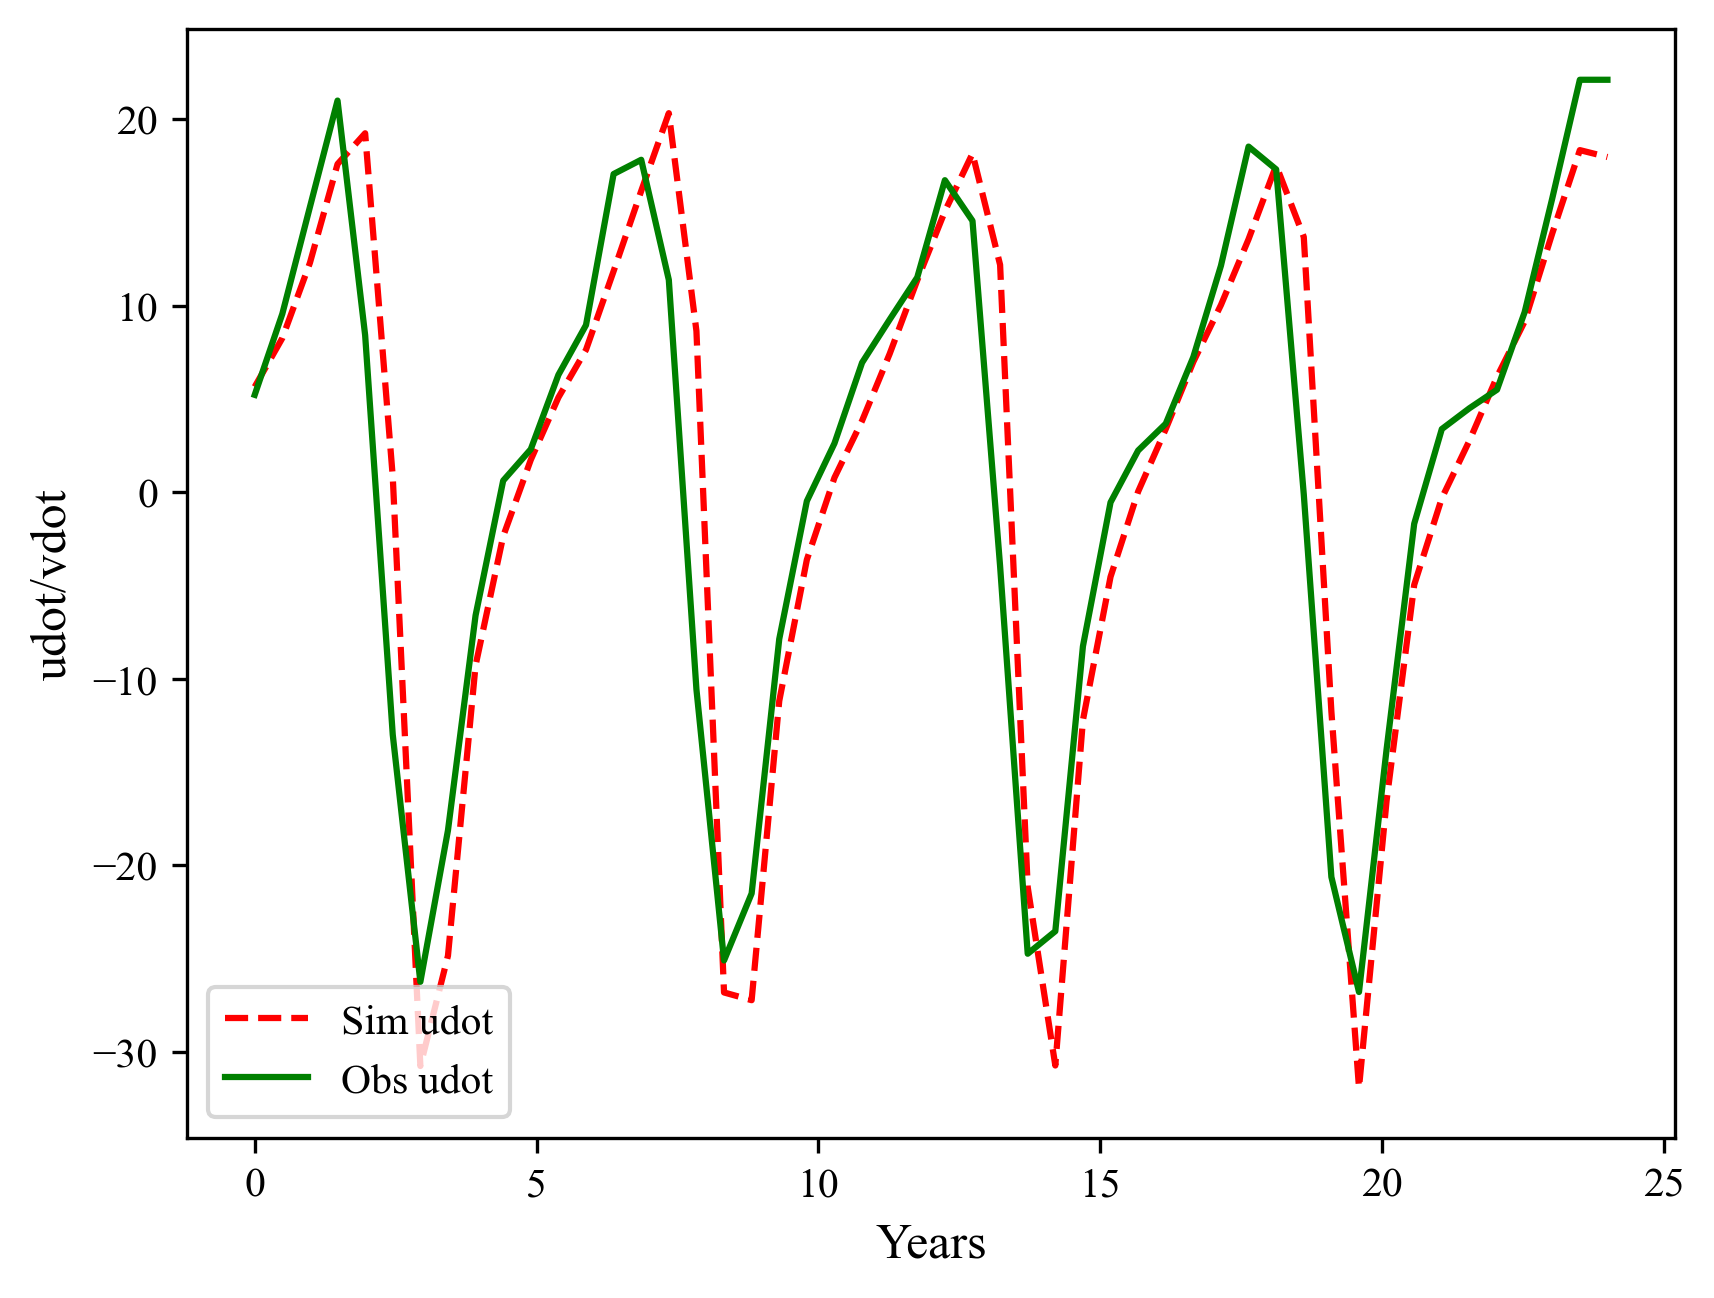

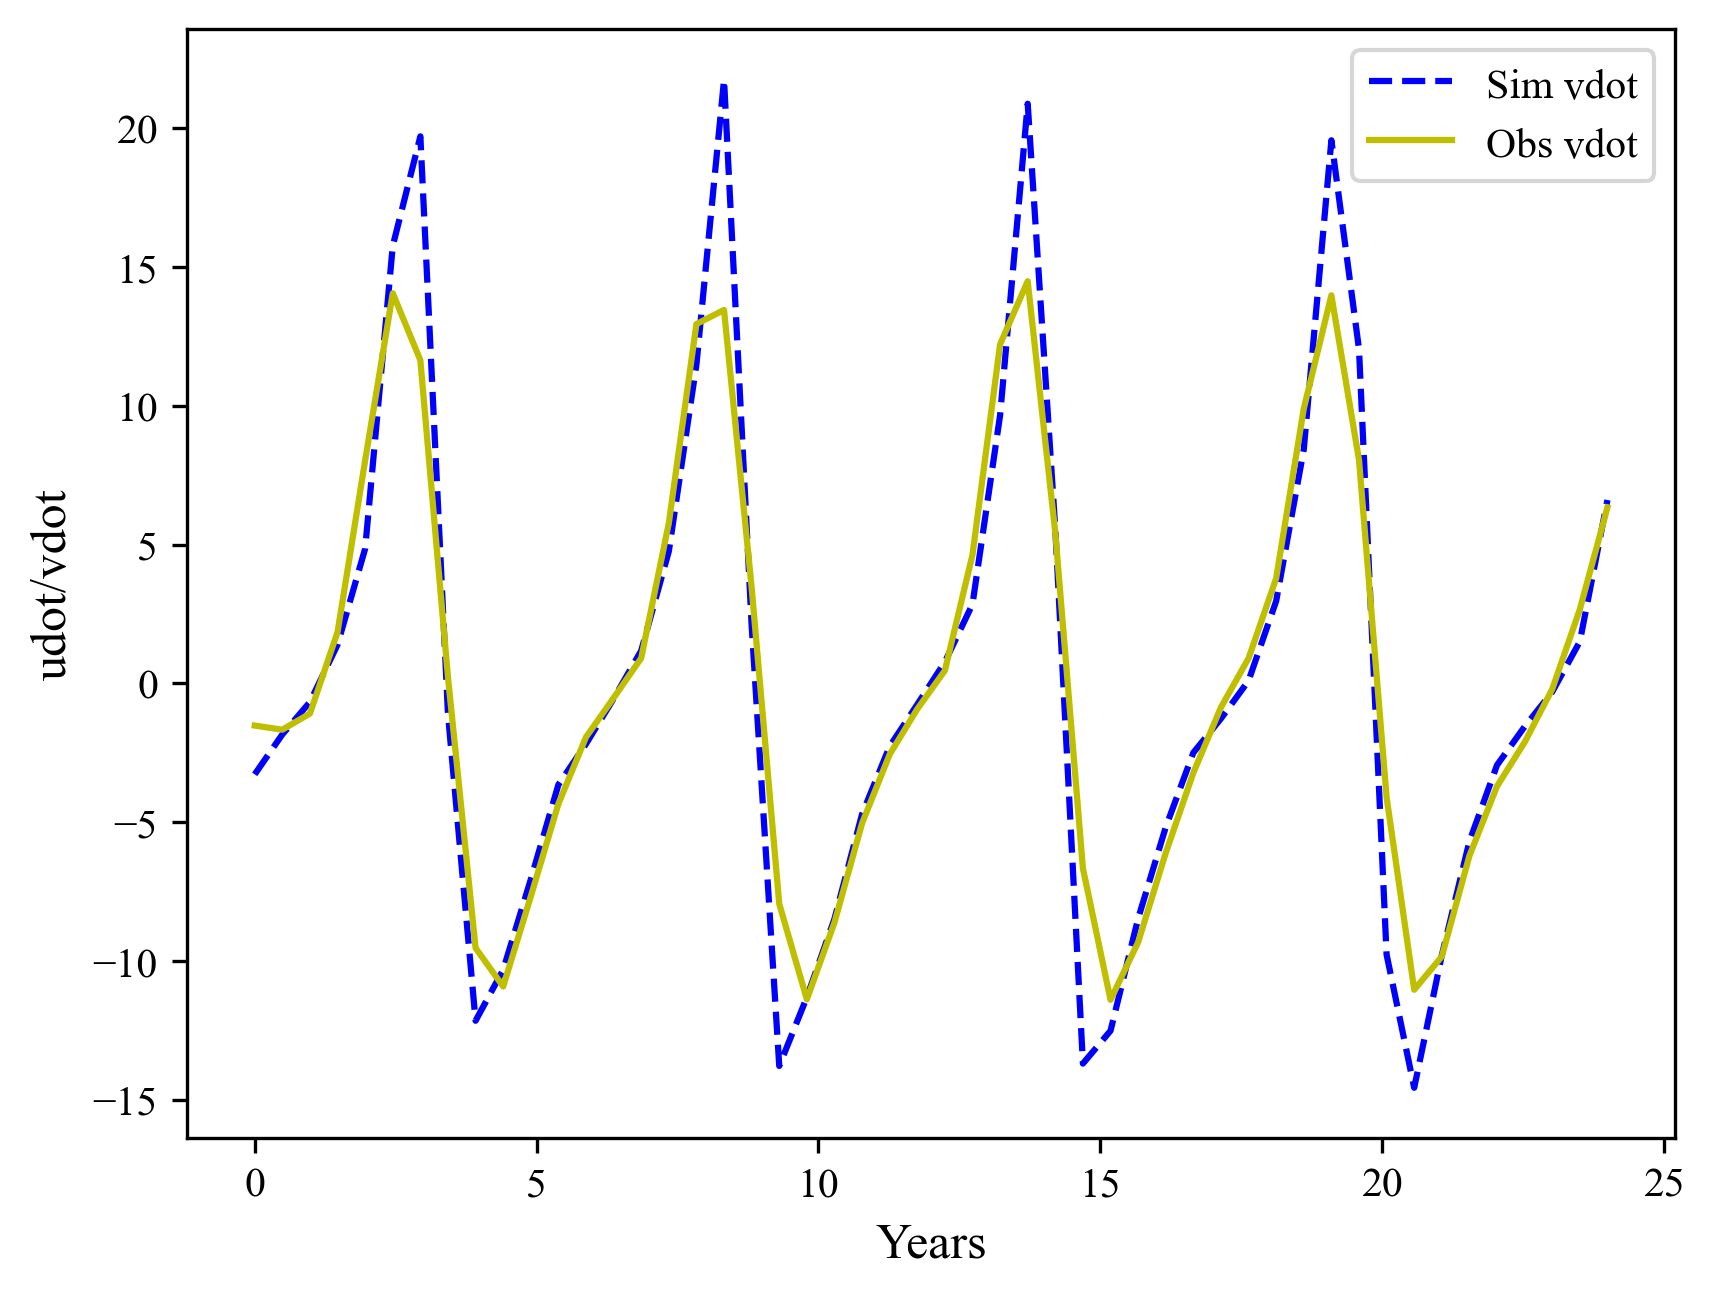

In [42]:
u_norm = x_noisy[:,0]
v_norm = x_noisy[:,1]
time =t
# Generate library data
library = generate_library(u_norm, v_norm)

# Define true parameters
u_param_true = [0, alpha, 0, -beta]
v_param_true = [0, 0, -gamma, delta]

# Simulate x_dot and v_dot
u_dot_true = simulate_param(u_param_true, library)
v_dot_true = simulate_param(v_param_true, library)

u_dot_noisy = differentiate(u_norm, time, wl=5, order=1)
v_dot_noisy = differentiate(v_norm, time, wl=5, order=2)

# compute the mse value
u_mse = mean_squared_error(u_dot_true, u_dot_noisy)
v_mse = mean_squared_error(v_dot_true, v_dot_noisy)
print(f'MSE value = {u_mse, v_mse}')

# plot the numerical differentiation and predicted
plt.plot(t, u_dot_true, 'r--', label='Sim udot')
plt.plot(t, u_dot_noisy, 'g', label='Obs udot')
plt.legend()
plt.xlabel(f'Years')
plt.ylabel(f'udot/vdot')
plt.show()

plt.plot(t, v_dot_true, 'b--', label='Sim vdot')
plt.plot(t, v_dot_noisy, 'y', label='Obs vdot')
plt.legend()
plt.xlabel(f'Years')
plt.ylabel(f'udot/vdot')
plt.show()

In [49]:
# SIP Method
# Bayesian Inference using PyMC3 to estimate parameters of Lotka-Volterra model
# Import functions used in SIP analysis from `my_functions`

import sampyl as smp
from scipy.stats import gaussian_kde

def ss_prior_fn(prior, spike_prob):
    if len(spike_prob) == prior.shape[-1]:
        spike_indicator = np.random.binomial(1, 1 - spike_prob, size=prior.shape)
        new_prior = spike_indicator * prior
    else:
        print(f'Length of spike probability does not match number of data columns')
        return None  # or you can raise an exception
    return new_prior

def calculate_noise_statistics(original, noisy):
    noise = noisy - original
    mean_noise = np.mean(noise, axis=0)
    std_noise = np.std(noise, axis=0)
    noise_percentage = (std_noise / np.mean(original, axis=0)) * 100
    snr = 20 * np.log10(np.mean(original, axis=0) / std_noise)
    return mean_noise, std_noise, noise_percentage, snr

def simulate_lotka_volterra(alpha, beta, gamma, delta, t, z0):
    def lotka_volterra(z, t):
        u, v = z
        du_dt = alpha * u - beta * u * v
        dv_dt = -gamma * v + delta * u * v
        return [du_dt, dv_dt]

    return odeint(lotka_volterra, z0, t)

# Generate prior samples
def generate_samples(mean, std, num_samples, distribution='normal'):
    if distribution == 'normal':
        samples = np.random.normal(mean, std, size=(num_samples, len(mean)))
    elif distribution == 'uniform':
        samples = np.random.uniform(mean, std, size=(num_samples, len(mean)))
    else:
        raise ValueError(f"Unknown distribution: {distribution}")
    return samples

# Perform KDE estimation
def estimate_kde(y_paths, bw_method='scott', dim=5, idx=False):
    data, indices = equally_spaced_elements(dim, y_paths) # y_paths[:,:dim]
    kde = gaussian_kde(data, bw_method=bw_method)
    if idx:
        return kde, indices
    else:
        return kde

# Rejection sampling
def rejection_sampling(samples_from_prior, Q, kde_obs, kde_prior, *args):
    def r(prior, Q=Q, kde_obs=kde_obs, kde_prior=kde_prior):
        push_prior = Q(prior, *args)
        kde_obs_pprior = kde_density_at_points(kde_obs, push_prior, dim=dim)
        kde_prior_pprior = kde_density_at_points(kde_prior, push_prior, dim=dim)
        return kde_obs_pprior / kde_prior_pprior

    r_values = r(samples_from_prior)
    M = np.max(r_values)
    accepted_samples = []
    for i, lambda_p in enumerate(samples_from_prior):
        r_Q_lambda = r_values[i]
        epsilon_p = np.random.uniform(0, 1)
        ratio_p = r_Q_lambda / M
        if ratio_p >= epsilon_p:
            accepted_samples.append(lambda_p)
    return np.array(accepted_samples)

# Define the SIP function
def SIP_method(alpha, beta, gamma, delta, t, z0, num_samples=1000):
    noise_params = calculate_noise_statistics(x_clean, x_noisy)
    library = generate_library(u_norm, v_norm)

    prior_mean = np.array([alpha, beta, gamma, delta])
    prior_std = np.array([0.1, 0.1, 0.1, 0.1])
    prior_samples = generate_samples(prior_mean, prior_std, num_samples)

    pushforward_prior = [simulate_param(params, library) for params in prior_samples]
    kde_obs = estimate_kde(x_noisy, bw_method='scott')
    kde_prior = estimate_kde(pushforward_prior, bw_method='scott')

    posterior_samples = rejection_sampling(prior_samples, simulate_param, kde_obs, kde_prior, library)
    return posterior_samples

 #Functions for UQ SINDy method
def equally_spaced_elements(n, array):
    p = array.shape[-1]
    if p <= n:
        raise ValueError("The length of the array must be greater than n.")
    indices = np.linspace(0, p-1, n, dtype=int)
    if array.ndim == 1:
        array = array.reshape(1, -1)
    if np.any(indices >= array.shape[1]):
        raise ValueError("Some indices are out of bounds for the given array.")
    extracted_elements = array[:, indices]
    return extracted_elements, indices

def estimate_kde(y_paths, bw_method='scott', dim=5, idx=False):
    data, indices = equally_spaced_elements(dim, y_paths)
    kde = KernelDensity(bandwidth=bw_method, kernel='gaussian')
    kde.fit(data)
    if idx:
        return kde, indices
    else:
        return kde

def kde_density_at_points(kde, points, dim=5):
    eval_points, indices = equally_spaced_elements(dim, points)
    log_densities = kde.score_samples(eval_points)
    densities = np.exp(log_densities)
    return densities

def rejection_sampling(samples_from_prior, Q, kde_obs, kde_prior, *args):
    def r(prior, Q=Q, kde_obs=kde_obs, kde_prior=kde_prior):
        push_prior = Q(prior, *args)
        kde_obs_pprior = kde_density_at_points(kde_obs, push_prior, dim=dim)
        kde_prior_pprior = kde_density_at_points(kde_prior, push_prior, dim=dim)
        return kde_obs_pprior / kde_prior_pprior
    r_values = r(samples_from_prior)
    M = np.max(r_values)
    accepted_samples = []
    for i, lambda_p in enumerate(samples_from_prior):
        r_Q_lambda = r_values[i]
        epsilon_p = np.random.uniform(0, 1)
        ratio_p = r_Q_lambda / M
        if ratio_p >= epsilon_p:
            accepted_samples.append(lambda_p)
    return np.array(accepted_samples)

def kl_divergence(p, q, bandwidth=1.0):
    kde_p = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(p)
    kde_q = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(q)
    points = kde_p.sample(n_samples=200)
    log_p_x = kde_p.score_samples(points)
    log_q_x = kde_q.score_samples(points)
    kl_p_q = np.sum(np.exp(log_p_x) * (log_p_x - log_q_x)) / points.shape[0]
    kl_q_p = np.sum(np.exp(log_q_x) * (log_q_x - log_p_x)) / points.shape[0]
    return kl_p_q, kl_q_p

def bootstrap_lotka_volterra(data):
    n = data.shape[1]
    indices = np.arange(1, n - 1)
    boot_indices = resample(indices, replace=False, n_samples=int(0.6 * len(indices)))
    boot_indices = np.sort(boot_indices)
    boot_indices = np.insert(boot_indices, 0, 0)
    boot_indices = np.append(boot_indices, n - 1)
    prey_sampled = data[0, boot_indices]
    predator_sampled = data[1, boot_indices]
    new_time_points = np.linspace(0, n - 1, n)
    interpolate_prey = interp1d(boot_indices, prey_sampled, kind='linear', fill_value="extrapolate")
    interpolate_predator = interp1d(boot_indices, predator_sampled, kind='linear', fill_value="extrapolate")
    new_prey_population = interpolate_prey(new_time_points)
    new_predator_population = interpolate_predator(new_time_points)
    return new_prey_population, new_predator_population

def generate_population_of_paths(prey_population, predator_population, samples=100):
    data = np.vstack([prey_population, predator_population])
    bootstrapped_samples = [bootstrap_lotka_volterra(data) for _ in range(samples)]
    return np.array(bootstrapped_samples)

# Function to simulate parameter
def simulate_param(params, library):
    params = np.array(params).reshape(-1,1)
    return np.dot(library, params).reshape(-1)

# Function to integrate x_dot
def integrate_x_dot(x_dot, t, init_val):
    from scipy.integrate import cumulative_trapezoid
    x = cumulative_trapezoid(x_dot, t, initial=0) + init_val
    return x

# Function to numerate parameter
def numerate_param(param, library, init_val, t=t):
    z_dot = simulate_param(param, library)
    z_intgrt = integrate_x_dot(z_dot, t, init_val)
    return z_intgrt

# Differentiate data
def differentiate(data, time, wl=5, order=3):
    smoothed_fd = ps.SmoothedFiniteDifference(order=order, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data, time)
    return dldt

# Function to simulate Lotka-Volterra system
def gofx(prior_param_samples, library):
    pushforward = [simulate_param(param, library) for param in prior_param_samples]
    return np.array(pushforward)

In [50]:
# Generate bootstrapped data paths for the analysis
bootstrapped_samples = generate_population_of_paths(u_data, v_data, samples=500)
x_noisy_paths = bootstrapped_samples[:,0]
y_noisy_paths =  bootstrapped_samples[:,1]

# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for xn in x_noisy_paths:
    plt.plot(t, xn, 'g.-', alpha=0.3)
plt.plot(t, u_sim, label='True Prey')
plt.plot(t, u_data, label='Noisy Prey')
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for yn in y_noisy_paths:
    plt.plot(t, yn, 'g.-', alpha=0.3)
plt.plot(t, v_sim, label='True Predator')
plt.plot(t, v_data, label='Noisy Predator')
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.show()

# Generate bootstrapped data (derivatives) paths for the analysis
x_dot_noisy, y_dot_noisy = u_dot_noisy, v_dot_noisy
bootstrapped_samples = generate_population_of_paths(x_dot_noisy, y_dot_noisy, samples=300)
x_noisy_paths = bootstrapped_samples[:,0]
y_noisy_paths =  bootstrapped_samples[:,1]

# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for xn in x_noisy_paths:
    plt.plot(t, xn, 'g.-', alpha=0.3)
plt.plot(t, u_dot_true, label='True Prey')
plt.plot(t, x_dot_noisy, label='Noisy Prey')
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for yn in y_noisy_paths:
    plt.plot(t, yn, 'g.-', alpha=0.3)
plt.plot(t, v_dot_true, label='True Predator')
plt.plot(t, y_dot_noisy, label='Noisy Predator')
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.show()



NameError: name 'resample' is not defined

In [3]:


# Generate prior samples
u_spike_prob = np.array([0.7, 0.1, 0.7, 0.1])
v_spike_prob = np.array([0.7, 0.7, 0.1, 0.1])
ss_prior = True

# Estimate KDE
dim = 150
method = 0.15
x_kde_obs, indices = estimate_kde(x_noisy_paths, dim=dim, bw_method=method, idx=True)
x_obs_densities = kde_density_at_points(x_kde_obs, x_noisy_paths, dim=dim)

# Set hyperparameters
num_prior = 5000
Normal = False

# Generate prior samples
if Normal:    
    x_prior_param_mean = np.array([0, 0.55, 0, -0.455])
    x_prior_param_std = np.array([0.001, 0.2, 0.001, 0.2]) 
    x_prior_param_samples = generate_samples(x_prior_param_mean, x_prior_param_std, num_prior, distribution='normal')
    if num_prior <= 1000:
        x_prior_param_samples = expand_2D_array(x_prior_param_samples)
    x_pushforward_prior = gofx(x_prior_param_samples, library)
else:
    x_prior_param_low =  np.array([-0.04, -1, -0.04, -1]) 
    x_prior_param_high = np.array([0.04, 1, 0.03, 1])
    x_prior_param_samples = generate_samples(x_prior_param_low, x_prior_param_high, num_prior, distribution='uniform')
    if num_prior <= 1000:
        x_prior_param_samples = expand_2D_array(x_prior_param_samples)
    x_pushforward_prior = gofx(x_prior_param_samples, library)

x_kde_prior = estimate_kde(x_pushforward_prior, dim=dim, bw_method=method)

# Run acceptance rejection sampling to generate posterior
x_post_param_samples = []
tym = 0
tym2 = 0
while len(x_post_param_samples) < 50:
    if len(x_post_param_samples) < 10:
        if Normal:
            x_prior_param_samples = generate_samples(x_prior_param_mean, x_prior_param_std, num_prior, distribution='normal')
        else: 
            x_prior_param_samples = generate_samples(x_prior_param_low, x_prior_param_high, num_prior, distribution='uniform')
        if ss_prior:
            x_prior_param_samples = ss_prior_fn(x_prior_param_samples, u_spike_prob)
        x_post_param_samples.extend(rejection_sampling(x_prior_param_samples, gofx, x_kde_obs, x_kde_prior, library))
        tym += 1
    else:
        if tym2 == 0:        
            x_prior_param_low =  np.min(x_post_param_samples, 0)  
            x_prior_param_high = np.max(x_post_param_samples, 0)
            tym2 += 1
        else:
            x_prior_param_low =  np.min(x_post_param_samples, 0)  
            x_prior_param_high = np.max(x_post_param_samples, 0)
            tym2 += 1
        x_prior_param_samples = generate_samples(x_prior_param_low, x_prior_param_high, n_samples=1000, distribution='uniform')
        if ss_prior:
            x_prior_param_samples = ss_prior_fn(x_prior_param_samples, u_spike_prob)
        x_pushforward_prior = gofx(x_prior_param_samples, library)
        x_kde_prior = estimate_kde(x_pushforward_prior, dim=dim, bw_method=method)
        temp = rejection_sampling(x_prior_param_samples, gofx, x_kde_obs, x_kde_prior, library)
        x_post_param_samples.extend(temp)
        tym += 1

x_post_param_samples = np.array(x_post_param_samples)
x_pushforward_posterior = gofx(x_post_param_samples, library)

# Visualize paths
plt.figure()
for path in x_pushforward_posterior:
    plt.plot(t, path, color='yellow', alpha=0.05)
x_mean_path = np.mean(x_pushforward_posterior, axis=0)
plt.plot(t, x_mean_path, 'g^', label='mean_post_path')
plt.plot(t, u_dot_true, 'k.', label='True data')
plt.plot(t, x_dot_noisy, 'r.', label='observed data')
plt.legend()
plt.show()

# KL divergence
kl_divs = kl_divergence(x_noisy_paths, x_pushforward_posterior, bandwidth=method)
print(kl_divs, np.mean(x_post_param_samples, 0), np.std(x_post_param_samples, 0))

# Generate prior samples for v_dot
if Normal:
    y_prior_param_mean = np.array([0, 0, -0.84, 0.5433])
    y_prior_param_std = np.array([0.02, 0.02, 0.2, 0.2])
    y_prior_param_samples = generate_samples(y_prior_param_mean, y_prior_param_std, num_prior, distribution='normal')
    if num_prior <= 1000:
        y_prior_param_samples = expand_2D_array(y_prior_param_samples)
    y_pushforward_prior = gofx(y_prior_param_samples, library)
else:
    y_prior_param_low = np.array([-0.04, -0.04, -1, -1])
    y_prior_param_high = np.array([0.04, 0.04, 1, 1])
    y_prior_param_samples = generate_samples(y_prior_param_low, y_prior_param_high, num_prior, distribution='uniform')
    if num_prior <= 1000:
        y_prior_param_samples = expand_2D_array(y_prior_param_samples)
    y_pushforward_prior = gofx(y_prior_param_samples, library)

y_kde_prior = estimate_kde(y_pushforward_prior, dim=dim, bw_method=method)

# Run acceptance rejection sampling to generate posterior for v_dot
y_post_param_samples = []
tym = 0
tym2 = 0
while len(y_post_param_samples) < 100:
    if len(y_post_param_samples) < 10:
        if Normal:
            y_prior_param_samples = generate_samples(y_prior_param_mean, y_prior_param_std, num_prior, distribution='normal')
        else:
            y_prior_param_samples = generate_samples(y_prior_param_low, y_prior_param_high, num_prior, distribution='uniform')
        if ss_prior:
            y_prior_param_samples = ss_prior_fn(y_prior_param_samples, v_spike_prob)
        y_post_param_samples.extend(rejection_sampling(y_prior_param_samples, gofx, y_kde_obs, y_kde_prior, library))
        tym += 1
    else:
        if tym2 == 0:
            y_prior_param_low = np.min(y_post_param_samples, 0)
            y_prior_param_high = np.max(y_post_param_samples, 0)
            tym2 += 1
        else:
            y_prior_param_low = np.min(y_post_param_samples, 0)  
            y_prior_param_high = np.max(y_post_param_samples, 0)
            tym2 += 1
        y_prior_param_samples = generate_samples(y_prior_param_low, y_prior_param_high, n_samples=1000, distribution='uniform')
        if ss_prior:
            y_prior_param_samples = ss_prior_fn(y_prior_param_samples, v_spike_prob)
        y_pushforward_prior = gofx(y_prior_param_samples, library)
        y_kde_prior = estimate_kde(y_pushforward_prior, dim=dim, bw_method=method)
        temp = rejection_sampling(y_prior_param_samples, gofx, y_kde_obs, y_kde_prior, library)
        y_post_param_samples.extend(temp)
        tym += 1

y_post_param_samples = np.array(y_post_param_samples)
y_pushforward_posterior = gofx(y_post_param_samples, library)

# Visualize paths
plt.figure()
for path in y_pushforward_posterior:
    plt.plot(t, path, color='yellow', alpha=0.05)
y_mean_path = np.mean(y_pushforward_posterior, axis=0)
plt.plot(t, y_mean_path, 'g^', label='mean_post_path')
plt.plot(t, v_dot_true, 'k.', label='True data')
plt.plot(t, y_dot_noisy, 'r.', label='observed data')
plt.legend()
plt.show()

# KL divergence
kl_divs = kl_divergence(y_noisy_paths, y_pushforward_posterior, bandwidth=method)
print(kl_divs, np.mean(y_post_param_samples, 0), np.std(y_post_param_samples, 0))

mf.save_array_to_csv(x_post_param_samples, 'lotka_sip_x_coeffs.csv')
mf.save_array_to_csv(y_post_param_samples, 'lotka_sip_y_coeffs.csv')

# UQSINDy Method

# Initialize the parameters (params and sigma)
u_start_params = np.zeros(4)
u_start_sigma = 0.01
num_step = 150

u_Posterior_params = []
u_Posterior_sigma = []
step = 0
while step < num_step:
    if step % 5 == 0:
        print(f'______________________________________________________________________{step}th iteration_________________________________________________________________')
    def log_likelihood(u_params):
        if ss_prior:
            u_params = ss_prior_fn(u_params, u_spike_prob)
        a, b, c, d = u_params
        sig = u_start_sigma
        udot_predict = simulate_param(u_params, library).reshape(-1)
        model = smp.Model()
        model.add(smp.normal(udot_predict, mu=u_dot_noisy, sig=sig))
        model.add(smp.uniform(a, lower=-1, upper=1),
                  smp.uniform(b, lower=-1, upper=1),
                  smp.uniform(c, lower=-1, upper=1),
                  smp.uniform(d, lower=-1, upper=1))
        return model()

    u_start_params_ltk = {'u_params': u_start_params}
    hmc_param_ltk = smp.Slice(log_likelihood, u_start_params_ltk)
    chain_param_ltk = hmc_param_ltk.sample(100, burn=50, n_chains=1)
    u_start_params = np.mean(chain_param_ltk.u_params, axis=0)

    def sigma_likelihood(u_sigma):
        sig = u_sigma
        udot_predict = simulate_param(u_start_params, library).reshape(-1)
        model = smp.Model()
        model.add(smp.normal(udot_predict, mu=u_dot_noisy, sig=sig))
        model.add(smp.exponential(sig))
        return model()

    start_eps_ltk = {'u_sigma': u_start_sigma}
    hmc_eps_ltk = smp.NUTS(sigma_likelihood, start_eps_ltk)
    chain_eps_ltk = hmc_eps_ltk.sample(100, burn=50, n_chains=1)
    u_start_sigma = np.mean(chain_eps_ltk.u_sigma, axis=0)

    u_Posterior_params.extend(chain_param_ltk.u_params)
    u_Posterior_sigma.extend(chain_eps_ltk.u_sigma)
    step += 1
    print(f'Recovered u_params = {u_start_params}')
    print(f'Recovered u_sigma = {u_start_sigma}\n\n')

print(np.mean(u_Posterior_params, axis=0), np.mean(u_Posterior_sigma, axis=0))

u_dot_post = simulate_param(np.mean(u_Posterior_params, axis=0), library)
plt.plot(t, u_dot_noisy, 'r*-')
plt.plot(t, u_dot_post)
plt.show()

v_start_params = np.zeros(4)
v_start_sigma = 0.2
num_step = 50

v_Posterior_params = []
v_Posterior_sigma = []
step = 0
while step < num_step:
    if step % 10 == 5:
        print(f'______________________________________________________________________{step}th iteration_________________________________________________________________')
    def log_likelihood(v_params):
        if ss_prior:
            v_params = ss_prior_fn(v_params, v_spike_prob)
        a, b, c, d = v_params
        sig = v_start_sigma
        vdot_predict = simulate_param(v_params, library).reshape(-1)
        model = smp.Model()
        model.add(smp.normal(vdot_predict, mu=v_dot_noisy, sig=sig))
        model.add(smp.uniform(a, lower=-1, upper=1),
                  smp.uniform(b, lower=-1, upper=1),
                  smp.uniform(c, lower=-1, upper=1),
                  smp.uniform(d, lower=-1, upper=1))
        return model()

    v_start_params_ltk = {'v_params': v_start_params}
    hmc_param_ltk = smp.Slice(log_likelihood, v_start_params_ltk)
    chain_param_ltk = hmc_param_ltk.sample(100, burn=50, n_chains=1)
    v_start_params = np.mean(chain_param_ltk.v_params, axis=0)

    def sigma_likelihood(v_sigma):
        sig = v_sigma
        vdot_predict = simulate_param(v_start_params, library).reshape(-1)
        model = smp.Model()
        model.add(smp.normal(vdot_predict, mu=v_dot_noisy, sig=sig))
        model.add(smp.exponential(sig))
        return model()

    start_eps_ltk = {'v_sigma': v_start_sigma}
    hmc_eps_ltk = smp.Slice(sigma_likelihood, start_eps_ltk)
    chain_eps_ltk = hmc_eps_ltk.sample(100, burn=50, n_chains=1)
    v_start_sigma = np.mean(chain_eps_ltk.v_sigma, axis=0)

    v_Posterior_params.extend(chain_param_ltk.v_params)
    v_Posterior_sigma.extend(chain_eps_ltk.v_sigma)
    step += 1
    print(f'Recovered v_params = {v_start_params}')
    print(f'Recovered v_sigma = {v_start_sigma}\n\n')

print(np.mean(v_Posterior_params, axis=0), np.mean(v_Posterior_sigma, axis=0))

v_dot_post = simulate_param(np.mean(v_Posterior_params, axis=0), library)
plt.plot(t, v_dot_noisy, 'r*-')
plt.plot(t, v_dot_post)
plt.show()

mf.save_array_to_csv(u_Posterior_params, 'lotka_uqsindy_x_coeffs.csv')
mf.save_array_to_csv(v_Posterior_params, 'lotka_uqsindy_y_coeffs.csv')

# Performance comparisons
def predict_lv_param(params):
    _, z_pred = integrate_lotka_volterra(t_span, z0, params, method='odeint', num_points=num_points)
    return z_pred

def lotka_volterra(t, z, a, b, g, d):
    u, v = z
    return [a*u + b*u*v, g*v + d*u*v]

def lotka_volterra_odeint(z, t, a, b, g, d):
    return [a*z[0] + b*z[0]*z[1], g*z[1] + d*z[0]*z[1]]

def integrate_lotka_volterra(t_span, z0, params, method='odeint', num_points=100):
    a, b, g, d = params
    numeric_params = [param if not isinstance(param, autograd.numpy.numpy_boxes.ArrayBox) else param._value for param in params]
    t_eval = np.linspace(*t_span, num_points)
    if method == 'solve_ivp':
        sol = solve_ivp(lambda t, z: lotka_volterra(t, z, *numeric_params), t_span, z0, t_eval=t_eval, method='RK45')
        z = sol.y
        t = sol.t
    elif method == 'odeint':
        sol = odeint(lotka_volterra_odeint, z0, t_eval, args=tuple(numeric_params))
        z = sol.T
        t = t_eval
    else:
        raise ValueError("Invalid method selected. Choose 'solve_ivp' or 'odeint'.")
    return t, z

def plot_histograms_in_one(*matrices):
    if len(set(m.shape[1] for m in matrices)) != 1:
        raise ValueError("All matrices must have the same number of columns")
    num_columns = matrices[0].shape[1]
    num_rows = len(matrices)
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(5 * num_columns, 4), squeeze=False)
    axes = axes.flatten()
    for col in range(num_columns):
        for idx, matrix in enumerate(matrices):
            column_data = matrix[:, col]
            mean_k = np.mean(column_data)
            sigma_k = np.std(column_data)
            axes[col].hist(column_data, bins=20, alpha=0.7, density=True, label=f'Matrix {idx+1} mean={mean_k:.2f}, $\sigma$={sigma_k:.2f}')
        axes[col].set_title(f'Column {col + 1}')
        axes[col].set_xlabel('Value')
        axes[col].set_ylabel('Frequency')
        axes[col].legend()
    plt.tight_layout()
    plt.show()

def plot_matrix_histograms(*matrices, hist_labels=['Observed data', 'SIP Posterior', 'PCE Posterior']):
    for index, matrix in enumerate(matrices):
        num_columns = matrix.shape[1]
        fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(4*num_columns, 3), squeeze=False)
        fig.suptitle(f'{hist_labels[i]}', fontsize=16)
        for col in range(num_columns):
            ax = axes[0, col]
            data = matrix[:, col]
            mean_k = np.mean(data)
            std_k = np.std(data)
            ax.hist(data, bins='auto', color='skyblue', alpha=0.7, rwidth=0.85, density=True)
            ax.set_title(f'Param {col+1} (mean={mean_k:.2f}, std={std_k:.2f})')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def plot_matrix_histograms(*matrices, colors=['red', 'blue', 'green'], hist_labels=['Observed data', 'SIP Posterior', 'PCE Posterior']):
    for index, matrix in enumerate(matrices):
        num_columns = matrix.shape[1]
        fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(4*num_columns, 3), squeeze=False)
        fig.suptitle(f'{hist_labels[index]}', fontsize=16)
        for col in range(num_columns):
            ax = axes[0, col]
            data = matrix[:, col]
            mean_k = np.mean(data)
            std_k = np.std(data)
            ax.hist(data, bins='auto', color=colors[index], alpha=0.7, rwidth=0.85, density=True)
            ax.axvline(mean_k, color='black', linestyle='dashed', linewidth=1)
            ax.set_title(f'Param {col+1} (mean={mean_k:.2f}, std={std_k:.2f})')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def plot_pushfowards(x_values, *y_paths_groups, show=False, colors=['red', 'blue', 'green'], hl='k*', labels=['Observed mean', 'SIP mean', 'PCE mean']):
    if colors is None:
        colors = ['blue'] * len(y_paths_groups)
    if labels is None:
        labels = [f'mean_path_{i+1}' for i in range(len(y_paths_groups))]
    plt.figure(figsize=(10, 6))
    for index, y_paths in enumerate(y_paths_groups):        
        mean_path = np.mean(y_paths, axis=0)
        plt.plot(x_values, mean_path, color=colors[index], label=labels[index % len(labels)])
    plt.title('Plots of Mean Paths')
    plt.xlabel('X Values')
    plt.ylabel('Y Values')
    plt.legend()
    plt.show()

    reference_y_paths = y_paths_groups[0]
    reference_density, _ = np.histogram(reference_y_paths, bins=30, density=True)
    for index, y_paths in enumerate(y_paths_groups):
        plt.figure(figsize=(10, 6))
        mean_path = np.mean(y_paths, axis=0)
        for path in y_paths:
            plt.plot(x_values, path, color=colors[index % len(colors)], alpha=0.3)
        plt.plot(x_values, mean_path, hl, label=labels[index % len(labels)])
        current_density, _ = np.histogram(y_paths, bins=30, density=True)
        kl_div = entropy(current_density, reference_density)
        plt.title(f'Plots of Paths (KL div w.r.t. first group: {kl_div:.2f})')
        plt.xlabel('X Values')
        plt.ylabel('Y Values')
        plt.legend()
        if show:
            plt.show()

def plot_kde_matrix(data, titles, color='orange', name='SIP method', xlim=(-2, 2)):
    data = np.array(data)
    n, m = data.shape
    mn, mx = np.min(data) - 0.05, np.max(data) + 0.05
    if len(titles) != m:
        raise ValueError("Length of titles vector must be equal to the number of columns in data.")
    fig, axes = plt.subplots(m, 1, figsize=(2.5, 1.5 * m), sharex='col', gridspec_kw={'hspace': 0})
    for i in range(m):
        kde = gaussian_kde(data[:, i])
        x = np.linspace(min(data[:, i]), max(data[:, i]), 1000)
        axes[i].plot(x, kde(x), color=color)
        axes[i].fill_between(x, kde(x), color=color, alpha=0.5)
        mean_val = np.mean(data[:, i])
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'mean= {mean_val.round(2)}')
        axes[i].axvline(0, color='black', linestyle='-.')
        axes[i].set_xlim(mn, mx)
        axes[i].set_ylabel(titles[i], rotation=0, labelpad=40)
        axes[i].legend(loc='upper right')
        axes[i].yaxis.set_label_position("left")
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(True)
        axes[i].get_xaxis().set_visible(True)
        axes[i].tick_params(axis='x', which='both', bottom=True)
        axes[i].tick_params(axis='y', which='both', left=False, right=False)
        axes[i].set_yticklabels([])
    plt.subplots_adjust(left=0.3)
    plt.xlabel('Value')
    plt.suptitle(name)
    plt.show()

# SIP posterior distribution
titles = ['1', 'u', 'v', 'uv']
plot_kde_matrix(x_post_param_samples, titles, color='orange', name='SIP u_dot')

plot_kde_matrix(y_post_param_samples, titles, color='orange', name='SIP v_dot')

# UQ SINDy posterior distribution
titles = ['1', 'u', 'v', 'uv']
plot_kde_matrix(u_Posterior_params, titles, color='orange', name='Bayesian u_dot')

plot_kde_matrix(v_Posterior_params, titles, color='orange', name='Bayesian v_dot')

def sim_lynx_hare(params):
    a, b, g, d = params
    params = (a, b, d, g)
    solution = odeint(lotka_volterra_system, initial_state, time, args=params)
    u_sim, v_sim = solution.T
    u_sim, v_sim = u_sim*u_scale, v_sim*v_scale
    return u_sim, v_sim

def recovered_lv(state, t, u_params, v_params):
    u, v = state
    a0, b0, c0, d0 = u_params
    a1, b1, c1, d1 = v_params    
    du_dt = a0*1 + b0*u + c0*v + d0*u*v
    dv_dt = a1*1 + b1*u + c1*v + d1*u*v
    return [du_dt, dv_dt]

def simulate_recovered_params(u_params, v_params):
    solution = odeint(recovered_lv, initial_state, time, args=(u_params, v_params,))
    u_sim, v_sim = solution.T
    u_sim, v_sim = u_sim*u_scale, v_sim*v_scale
    return u_sim, v_sim

# true parameters
u_true = [0, 0.55, 0, -0.455]
v_true = [0, 0, -0.84, 0.5433]
u_tmp, v_tmp = simulate_recovered_params(u_true, v_true)

# SIP posterior path plot
plt.plot(time, u_tmp)
plt.plot(time, u_data)
plt.show()

# SIP SINDy posterior simulation
u_postmean_sip = np.mean(x_post_param_samples, axis=0)
v_postmean_sip = np.mean(y_post_param_samples, axis=0)

u_post_sip, v_post_sip = simulate_recovered_params(u_postmean_sip, v_postmean_sip)

print(f'SIP u_mse = {mean_squared_error(u_sim, u_post_sip)}')
print(f'SIP v_mse = {mean_squared_error(v_sim, v_post_sip)}\n\n')

# UQ SINDy posterior simulation
u_postmean_uq = np.mean(u_Posterior_params, axis=0)
v_postmean_uq = np.mean(v_Posterior_params, axis=0)

u_post_uq, v_post_uq = simulate_recovered_params(u_postmean_uq, v_postmean_uq)

print(f'UQ u_mse = {mean_squared_error(u_sim, u_post_uq)}')
print(f'UQ v_mse = {mean_squared_error(v_sim, v_post_uq)}')

# plot and compare simulation versus observed data
plt.figure()
plt.title('Prey comparison')
plt.plot(t, u_sim, label='True')
plt.plot(t, u_post_uq, label='Bayes')
plt.plot(t, u_post_sip, label='SIP')
plt.plot(t, u_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.legend()
plt.show()

plt.figure()
plt.title('Predator comparison')
plt.plot(t, v_sim, label='True')
plt.plot(t, v_post_uq, label='Bayes')
plt.plot(t, v_post_sip, label='SIP')
plt.plot(t, v_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
plt.plot(u_sim, v_sim, label='True')
plt.plot(u_post_meanpath_uq, v_post_meanpath_uq, label='Bayes')
plt.plot(u_post_meanpath_sip, v_post_meanpath_sip, label='SIP')
plt.plot(u_data, v_data, label='Obsv')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.legend()
plt.show()

# mean path (mp) recovery
u_sip_mp = u_postmean_sip
u_bayes_mp = u_postmean_uq
v_sip_mp = v_postmean_sip
v_bayes_mp = v_postmean_uq

u_recv_params = [u_sip_mp, u_bayes_mp, v_sip_mp, v_bayes_mp]
true_params = [u_true, u_true, v_true, v_true]
u_names = ['u_sip_mp', 'u_bayes_mp', 'v_sip_mp', 'v_bayes_mp']
for i, u_rcv in enumerate(u_recv_params):
    print(f'MSE {u_names[i]} = {np.sqrt(mean_squared_error(true_params[i], u_rcv)).round(5)}')

from tqdm import tqdm
# SIP posterior path simulation
u_sip_post_paths = []
v_sip_post_paths = []
lent = min(len(x_post_param_samples), len(y_post_param_samples), 300)
for i in tqdm(range(lent)):
    u_param_i = x_post_param_samples[i]
    v_param_i = y_post_param_samples[i]
    u_tmp, v_tmp = simulate_recovered_params(u_param_i, v_param_i)
    if mean_squared_error(u_sim, u_tmp) <= 2000:
        u_sip_post_paths.append(u_tmp)
    if mean_squared_error(v_sim, v_tmp) <= 2000:
        v_sip_post_paths.append(v_tmp)
u_sip_post_paths = np.array(u_sip_post_paths)
v_sip_post_paths = np.array(v_sip_post_paths)

# Bayes posterior path simulation
u_uq_post_paths = []
v_uq_post_paths = []
lent = min(len(u_Posterior_params), len(v_Posterior_params), 300)
for i in tqdm(range(lent)):
    u_param_i = u_Posterior_params[i]
    v_param_i = v_Posterior_params[i]
    u_tmp, v_tmp = simulate_recovered_params(u_param_i, v_param_i)
    if mean_squared_error(u_sim, u_tmp) <= 2000:
        u_uq_post_paths.append(u_tmp)
    if mean_squared_error(v_sim, v_tmp) <= 2000:
        v_uq_post_paths.append(v_tmp)
u_uq_post_paths = np.array(u_uq_post_paths)
v_uq_post_paths = np.array(v_uq_post_paths)

u_post_meanpath_sip = np.mean(u_sip_post_paths, axis=0)
v_post_meanpath_sip = np.mean(v_sip_post_paths, axis=0)
u_post_meanpath_uq = np.mean(u_uq_post_paths, axis=0)
v_post_meanpath_uq = np.mean(v_uq_post_paths, axis=0)

print(f'SIP u_mse = {np.sqrt(mean_squared_error(u_sim, u_post_meanpath_sip))}')
print(f'SIP v_mse = {np.sqrt(mean_squared_error(v_sim, v_post_meanpath_sip))}\n\n')
print(f'UQ u_mse = {np.sqrt(mean_squared_error(u_sim, u_post_meanpath_uq))}')
print(f'UQ v_mse = {np.sqrt(mean_squared_error(v_sim, v_post_meanpath_uq))}')

# plot and compare simulation versus observed data
plt.figure()
plt.title('Prey comparison')
plt.plot(t, u_sim, label='True')
plt.plot(t, u_post_meanpath_uq, label='Bayes')
plt.plot(t, u_post_meanpath_sip, label='SIP')
plt.plot(t, u_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.ylim(0,140)
plt.legend()
plt.show()

plt.figure()
plt.title('Predator comparison')
plt.plot(t, v_sim, label='True')
plt.plot(t, v_post_meanpath_uq, label='Bayes')
plt.plot(t, v_post_meanpath_sip, label='SIP')
plt.plot(t, v_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.ylim(0,80)
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
plt.plot(u_sim, v_sim, label='True')
plt.plot(u_post_meanpath_uq, v_post_meanpath_uq, label='Bayes')
plt.plot(u_post_meanpath_sip, v_post_meanpath_sip, label='SIP')
plt.plot(u_data, v_data, label='Obsv')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.ylim(0,100)
plt.xlim(0,140)
plt.legend()
plt.show()

# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(u_sip_post_paths)):
    xn = u_sip_post_paths[i]
    plt.plot(t, xn, 'g', alpha=0.3)
plt.plot(t, u_post_meanpath_sip, 'k-', label='SIP mean path')
plt.plot(t, u_data, 'r-', label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(u_uq_post_paths)):
    xn = u_uq_post_paths[i]
    plt.plot(t, xn, 'g', alpha=0.3)
plt.plot(t, u_post_meanpath_uq, 'k-', label='Bayes mean path')
plt.plot(t, u_data, 'r-', label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.ylim(0, 140)
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(v_sip_post_paths)):
    yn = v_sip_post_paths[i]
    plt.plot(t, yn, 'g', alpha=0.3)
plt.plot(t, v_sim, 'b-.', label='True')
plt.plot(t, v_post_meanpath_sip, 'k-', label='SIP mean path')
plt.plot(t, v_data, 'r-', label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(v_uq_post_paths)):
    yn = v_uq_post_paths[i]
    plt.plot(t, yn, 'g', alpha=0.3)
plt.plot(t, v_sim, 'b-.', label='True')
plt.plot(t, v_post_meanpath_uq, 'k-', label='Bayes mean path')
plt.plot(t, v_data, 'r-', label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.ylim(0, 120)
plt.legend()
plt.show()

['Hudson_bay_data',
 'calculate_noise_statistics',
 'defvjp',
 'estimate_noise_statistics',
 'expand_2D_array',
 'gaussian_process_interpolation',
 'generate_samples',
 'grad_safe_sqrt',
 'load_csv_to_array',
 'mean_squared_error',
 'odeint',
 'plot_kde_matrix',
 'plot_paths',
 'primitive',
 'safe_sqrt',
 'safe_std',
 'save_array_to_csv',
 'set_publcn_matplotlib_defaults']

In [12]:
mf.set_publcn_matplotlib_defaults()